In [36]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [37]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from albumentations.pytorch import ToTensorV2

import albumentations as A
import monai

from colorama import Fore, Back, Style
c_  = Fore.GREEN
sr_ = Style.RESET_ALL

import time
from collections import defaultdict
import copy
import gc

from utils.dataset import EchoDataset
from utils.train import *
from utils.evaluation import *
from utils.optimizer import *
from utils.utils import *

import wandb

In [38]:
### Logging part
import logging
from datetime import datetime
from pytz import timezone
import sys

import random

def log(CFG):
    logger = logging.getLogger()
    logger.setLevel(logging.INFO)
    def timetz(*args):
        return datetime.now(tz).timetuple()
    tz = timezone('Asia/Seoul')
    logging.Formatter.converter = timetz

    formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
    # log 출력
    stream_handler = logging.StreamHandler()
    stream_handler.setFormatter(formatter)
    logger.addHandler(stream_handler)

    # log를 파일에 출력
    file_handler = logging.FileHandler(os.path.join('saved_model', CFG['version'], f"{CFG['view']}-{CFG['dataset']}-{CFG['backbone']}.log"))
    file_handler.setFormatter(formatter)
    logger.addHandler(file_handler)

    logger.info(f"python {' '.join(sys.argv)}")
    logger.info("Timezone: " + str(tz))
    logger.info(f"Training Start")
    return logger


In [39]:
def seed_everything(seed: int=0):    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
seed_everything()

## ⚙️ Configuration

In [40]:
view2cls_dict = {
    'PLAX': 3,
    'PSAX': 0,
    '2CH': 2,
    '4CH': 2,
}
class cfg:
    def __getitem__(self,key):
        return getattr(self, key)
    def __setitem__(self,key,value):
        return setattr(self, key, value)

    height = 375   
    width = 500
    view = 'PLAX'
    dataset = 'EchoNetLVH'
    lr = 1e-3
    scheduler = 'LambdaLR'
    reducelr_factor = 0.99
    min_lr = 1e-5
    device = torch.device('mps')
    epochs = 200
    patience = 50
    batch_size = 16

    ##############
    backbone = 'resnet101'
    version = '0.21'
    
CFG = cfg()

os.makedirs(os.path.join('saved_model', CFG['version']), exist_ok=True)

In [41]:

logger = log(CFG)
trace_func = logger.info

2022-10-15 11:42:46,061 - python /opt/homebrew/Caskroom/miniconda/base/envs/torch/lib/python3.8/site-packages/ipykernel_launcher.py -f /Users/kyh/Library/Jupyter/runtime/kernel-b9fdbacb-58a9-4a17-9173-61b184ca56bc.json


2022-10-15 11:42:46,061 - root - INFO - python /opt/homebrew/Caskroom/miniconda/base/envs/torch/lib/python3.8/site-packages/ipykernel_launcher.py -f /Users/kyh/Library/Jupyter/runtime/kernel-b9fdbacb-58a9-4a17-9173-61b184ca56bc.json
2022-10-15 11:42:46,061 - root - INFO - python /opt/homebrew/Caskroom/miniconda/base/envs/torch/lib/python3.8/site-packages/ipykernel_launcher.py -f /Users/kyh/Library/Jupyter/runtime/kernel-b9fdbacb-58a9-4a17-9173-61b184ca56bc.json


2022-10-15 11:42:46,062 - Timezone: Asia/Seoul


2022-10-15 11:42:46,062 - root - INFO - Timezone: Asia/Seoul
2022-10-15 11:42:46,062 - root - INFO - Timezone: Asia/Seoul


2022-10-15 11:42:46,063 - Training Start


2022-10-15 11:42:46,063 - root - INFO - Training Start
2022-10-15 11:42:46,063 - root - INFO - Training Start


In [42]:
dataset_dir = 'output'

## 📀 Load Data

In [43]:
from albumentations.core.transforms_interface import ImageOnlyTransform

class MinMaxNormalize(ImageOnlyTransform):
    """
    Min-max normalization
    """
    def apply(self, img, **param):
        # minmax normalize
        img = (img - img.min()) / (img.max() - img.min())
        return img


In [44]:
train_ts = A.Compose([
    A.Resize(CFG['height'], CFG['width']),
    # A.HorizontalFlip(p=.5),
    A.VerticalFlip(p=.3),
    # A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2,
    #                 rotate_limit=10, p=0.2),
    A.SafeRotate(limit=30),

    A.OneOf([
        A.MedianBlur(blur_limit=3, p=0.1),
        A.MotionBlur(p=0.2),
    ], p=0.2),
    # A.OneOf([
    #     A.OpticalDistortion(p=0.3),
    # ], p=0.2),
    A.OneOf([
        A.GaussNoise(p=0.2),
        A.MultiplicativeNoise(p=0.2),
    ], p=0.2),
    A.HueSaturationValue(hue_shift_limit=0, sat_shift_limit=0,
                         val_shift_limit=0.1, p=0.3),
    MinMaxNormalize(p=1),

    # ToTensorV2(),

],
    keypoint_params=A.KeypointParams(format='xy')
)
test_ts = A.Compose([
        A.Resize(CFG['height'], CFG['width']),
        MinMaxNormalize(p=1),
        # ToTensorV2(),
        ],
        keypoint_params=A.KeypointParams(format='xy')
        )


In [45]:
ds = EchoDataset(root=dataset_dir, split='train', transforms=train_ts)
dl = DataLoader(ds, batch_size=1, shuffle=False, )
s = dl.__iter__().__next__()
s

{'data': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],
 
          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],
 
          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]]]),
 'label': tensor([[263.2901, 166.6771, 268.8970, 150.2701, 228.6763, 264.6503, 234.2717,
          247.2822, 234.2717, 247.2822, 263.2901, 166.6771]]),
 'id': [

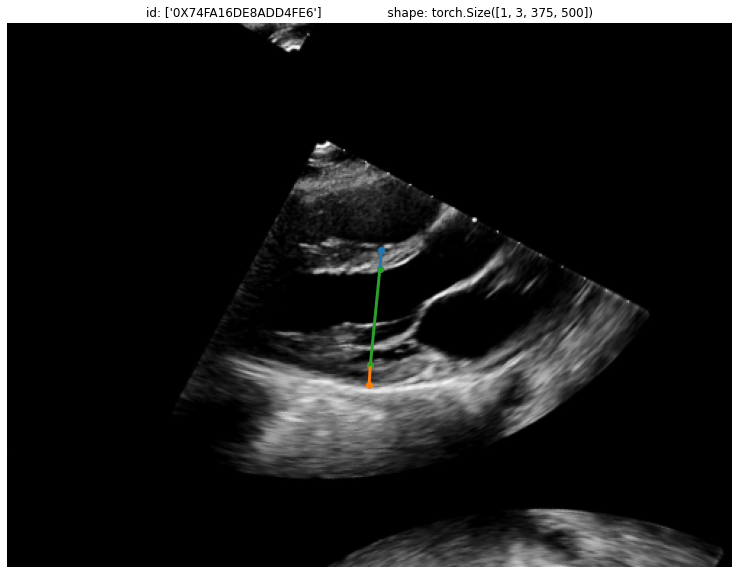

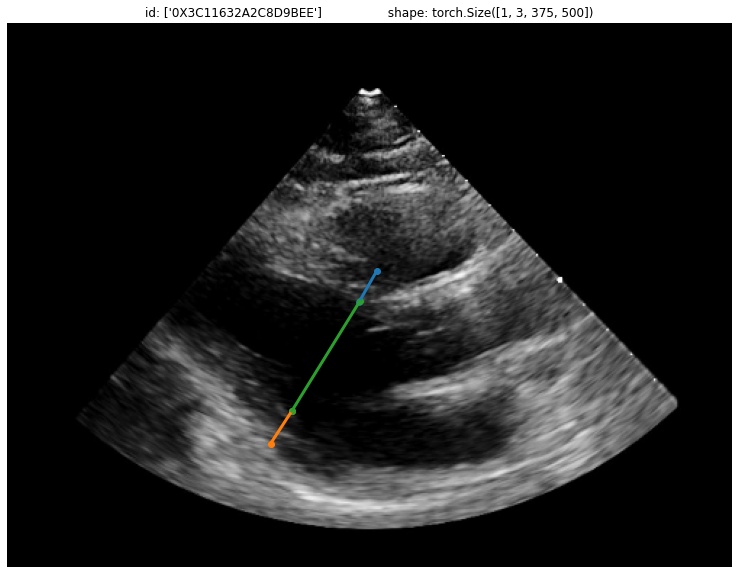

In [46]:
for i, sample in enumerate(dl):
    show_lvh(sample)
    if i == 1:
        break

In [47]:
train_ds = EchoDataset(root=dataset_dir, split='train', transforms=train_ts)
valid_ds = EchoDataset(root=dataset_dir, split='val', transforms=test_ts)

train_dl = DataLoader(train_ds, batch_size=CFG.batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=CFG.batch_size//2, shuffle=False)

## 🧮 Load Model

In [48]:
# 0.2, 0.21
import torch.nn.functional as F
class Model_resnet(nn.Module):
    def __init__(self, backbone, in_channels, out_channels, ):
        super().__init__()
        # self.input = nn.Conv2d(in_channels=1, out_channels=3, kernel_size=1)
        for param in backbone.parameters():
            param.requires_grad = True
        self.backbone = nn.Sequential(
                                      *(list(backbone.children())[:-2]),
                                      )   
        # resnet34: 512
        # resnet101: 2048    
        self.fc = nn.Linear(in_features=2048, out_features=out_channels*2*2, bias=True)
    def forward(self, x):
        # x = self.input(x)
        out = self.backbone(x)
        # out = F.relu(out, inplace=False)
        out = F.adaptive_avg_pool2d(out, output_size=(1,1)).view(x.size(0), -1)
        out = self.fc(out)
        # out = F.relu(out)
        return out
    

In [49]:
import torch.nn.functional as F
class Model(nn.Module):
    def __init__(self, backbone, in_channels, out_channels, ):
        super().__init__()
        # self.input = nn.Conv2d(in_channels=1, out_channels=3, kernel_size=1)
        for param in backbone.features.parameters():
            param.requires_grad = True
        self.backbone = backbone.features
        # self.backbone = nn.Sequential(
        #                               *(list(backbone.children())[:-1]),
        #                               )   
        self.fc1 = nn.Linear(in_features=1024, out_features=512, bias=True)
        self.fc2 = nn.Linear(in_features=512, out_features=out_channels*2*2, bias=True)
    def forward(self, x):
        # x = self.input(x)
        out = self.backbone(x)
        # out = F.relu(out, inplace=False)
        out = F.adaptive_avg_pool2d(out, output_size=(1,1)).view(x.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        # out = F.relu(out)
        return out
    

In [50]:
# model = Model(
#                 torchvision.models.densenet121(weights=False),
#                 1,
#                 3
#             )
# model(torch.zeros(2,3,256,256)).shape

## 🤖 Run Model

In [51]:
from utils.train import train_one_epoch, valid_one_epoch

In [52]:

def run_training(model, train_dl, val_dl, optimizer, scheduler, criterion, CFG, wandb):
    """
    모델, 데이터를 받아 학습/검증 수행후 결과에 대해 출력 및 모델 저장
    """
    device = CFG['device']
    num_epochs = CFG['epochs']
    start = time.time()
    early_stopping = EarlyStopping(patience=CFG['patience'], verbose=True, trace_func=trace_func)

    best_model_wts = copy.deepcopy(model.state_dict())
    best_mde = np.inf
    best_loss = 
    best_epoch = -1
    history = defaultdict(list)
    # 에폭만큼 학습 수행
    for epoch in range(1, num_epochs+1):
        gc.collect()
        # 에폭 단위 학습 수행
        train_loss, train_mde = train_one_epoch(model=model, dataloader=train_dl, optimizer=optimizer, scheduler=scheduler, device=device, criterion=criterion, CFG=CFG)
        # 에폭 단위 검증 수행
        val_loss, val_mde = valid_one_epoch(model=model, dataloader=val_dl, device=device, criterion=criterion, CFG=CFG)
        early_stopping(val_loss, model)

        history['Train Loss'].append(train_loss)
        history['Train MDE'].append(train_mde)
        history['Valid Loss'].append(val_loss)
        history['Valid MDE'].append(val_mde)
        
        wandb.log({"Train Loss": train_loss, 
            "Train MDE": train_mde,
            "Valid Loss": val_loss,
            "Valid MDE": val_mde,
            "LR":scheduler.get_last_lr()[0]})

        trace_func(f"[Epoch {epoch}/{CFG['epochs']}: Train Loss: {train_loss:.5f}, Val Loss: {val_loss:.5f}, Train MDE: {train_mde:.5f}, Val MDE: {val_mde:.5f}")
        
        if scheduler is not None:
            scheduler.step()
        # validation MDE가 개선이 된 경우 모델을 저장
        if val_mde <= best_mde:
            trace_func(f"Valid Score Improved ({best_mde:.4f} ---> {val_mde:.4f})")
            best_mde = val_mde
            best_epoch = epoch
            best_model_wts = copy.deepcopy(model.state_dict())
            
            wandb.run.summary['Best MDE'] = best_mde
            wandb.run.summary['Best Epoch'] = best_epoch

            model_name = f"best_epoch-{CFG['view']}-{CFG['dataset']}-{CFG['backbone']}.pth"
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict':optimizer.state_dict(),
                'loss': val_loss,
                'metric': val_mde
                }, 
                os.path.join(f"saved_model", CFG['version'], model_name))

            trace_func(f"Model Saved")
        # Loss 최소일때
        if best_loss 
        if early_stopping.early_stop:
            trace_func("Early stopping")
            break

    model_name = f"last_epoch-{CFG['view']}-{CFG['dataset']}-{CFG['backbone']}.pth"
    torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict':optimizer.state_dict(),
                'loss': val_loss
                }, 
                os.path.join(f"saved_model", CFG['version'], model_name))
    
    end = time.time()
    time_elapsed = end-start
    trace_func("Trianing complete in {:.0f}h {:.0f}m {:.0f}s".format(time_elapsed//3600, (time_elapsed%3600)//60, (time_elapsed%3600)%60))
    trace_func("Best Val MDE: {:.4f}".format(best_mde))

    model.load_state_dict(best_model_wts)

    return model, history

In [53]:
model = Model_resnet(
                torchvision.models.resnet101(weights=None),
                1,
                3
            )
optimizer = torch.optim.Adam(params=model.parameters(), lr=CFG.lr)
criterion = nn.MSELoss()

KeyboardInterrupt: 

In [ ]:
run = wandb.init(project='2022KOHI_keypoint_detection',
                group=CFG['version'],
                name= f"View-{CFG['view']}|Dataset-{CFG['dataset']}|Backbone-{CFG['backbone']}",
                entity='kyh',
                # config={k:v for k, v in CFG.items() if '__' not in k}
                config={attr: CFG[attr] for attr in dir(CFG) if not callable(getattr(CFG, attr)) and not attr.startswith("__")},
                )

model, hist = run_training(model=model.to(CFG['device']),
             train_dl=train_dl, 
             val_dl=valid_dl, 
             optimizer=optimizer, 
             scheduler=fetch_scheduler(CFG, optimizer), 
             criterion=criterion, 
             CFG=CFG,
             wandb=wandb)
wandb.run.finish()

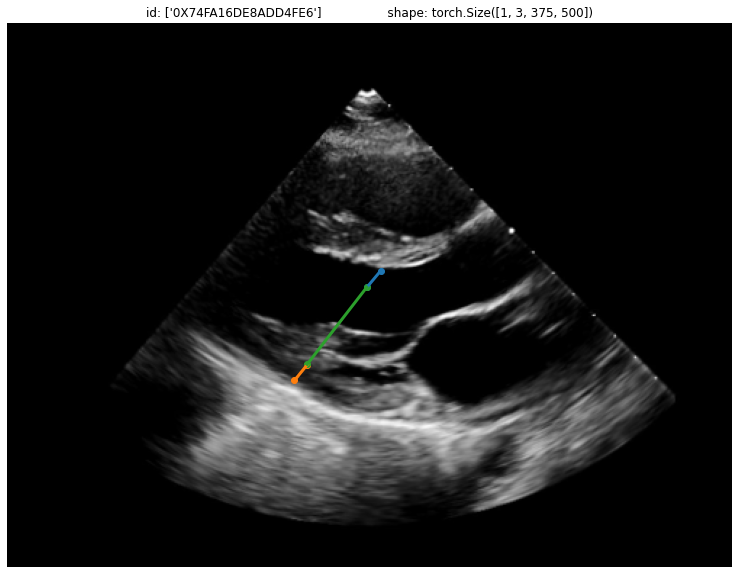

In [ ]:
show_lvh(s, )

In [54]:
valid_dl = DataLoader(valid_ds, batch_size=1, shuffle=False)
preds = []
for sample in valid_dl:
    pred = model(sample['data'].to(CFG['device'])).detach().cpu()
    # show_lvh(sample)
    # show_lvh(sample, pred)
    preds.append(pred)

KeyboardInterrupt: 

In [57]:
train_ds = EchoDataset(root=dataset_dir, split='train', transforms=test_ts)
train_dl = DataLoader(train_ds, batch_size=1, shuffle=False)
preds = []
for sample in valid_dl:
    pred = model(sample['data'].to(CFG['device'])).detach().cpu()
    # show_lvh(sample)
    # show_lvh(sample, pred)
    preds.append(pred)

KeyboardInterrupt: 

In [58]:
preds

[tensor([[243.3632, 178.9040, 252.8679, 167.9269, 193.3684, 240.5994, 202.2473,
          230.1483, 202.1174, 229.9897, 243.1782, 178.9971]]),
 tensor([[238.2552, 175.1340, 247.5654, 163.8807, 189.1794, 238.7949, 197.8918,
          227.9666, 197.7724, 227.7464, 238.0839, 175.2174]]),
 tensor([[249.5625, 183.1179, 259.1228, 172.2337, 199.4500, 244.2173, 208.3176,
          233.8045, 208.2000, 233.6462, 249.3667, 183.2248]]),
 tensor([[243.7360, 178.9377, 253.1590, 167.8113, 194.2126, 241.5483, 202.9932,
          230.9035, 202.8751, 230.7155, 243.5506, 179.0118]]),
 tensor([[243.9366, 179.2642, 253.2990, 168.5844, 194.7606, 239.1947, 203.4644,
          228.9319, 203.3219, 228.7748, 243.7429, 179.3581]]),
 tensor([[234.6943, 172.4137, 243.8552, 161.0273, 186.3719, 236.8757, 194.9453,
          225.9258, 194.8322, 225.6921, 234.5299, 172.4901]]),
 tensor([[240.4613, 176.6579, 249.8237, 165.2610, 191.1532, 241.1612, 199.8968,
          230.1842, 199.7804, 229.9706, 240.2942, 176.7488]]),

In [56]:
preds

[tensor([[243.3632, 178.9040, 252.8679, 167.9269, 193.3684, 240.5994, 202.2473,
          230.1483, 202.1174, 229.9897, 243.1782, 178.9971]]),
 tensor([[238.2552, 175.1340, 247.5654, 163.8807, 189.1794, 238.7949, 197.8918,
          227.9666, 197.7724, 227.7464, 238.0839, 175.2174]]),
 tensor([[249.5625, 183.1179, 259.1228, 172.2337, 199.4500, 244.2173, 208.3176,
          233.8045, 208.2000, 233.6462, 249.3667, 183.2248]]),
 tensor([[243.7360, 178.9377, 253.1590, 167.8113, 194.2126, 241.5483, 202.9932,
          230.9035, 202.8751, 230.7155, 243.5506, 179.0118]]),
 tensor([[243.9366, 179.2642, 253.2990, 168.5844, 194.7606, 239.1947, 203.4644,
          228.9319, 203.3219, 228.7748, 243.7429, 179.3581]]),
 tensor([[234.6943, 172.4137, 243.8552, 161.0273, 186.3719, 236.8757, 194.9453,
          225.9258, 194.8322, 225.6921, 234.5299, 172.4901]]),
 tensor([[240.4613, 176.6579, 249.8237, 165.2610, 191.1532, 241.1612, 199.8968,
          230.1842, 199.7804, 229.9706, 240.2942, 176.7488]]),

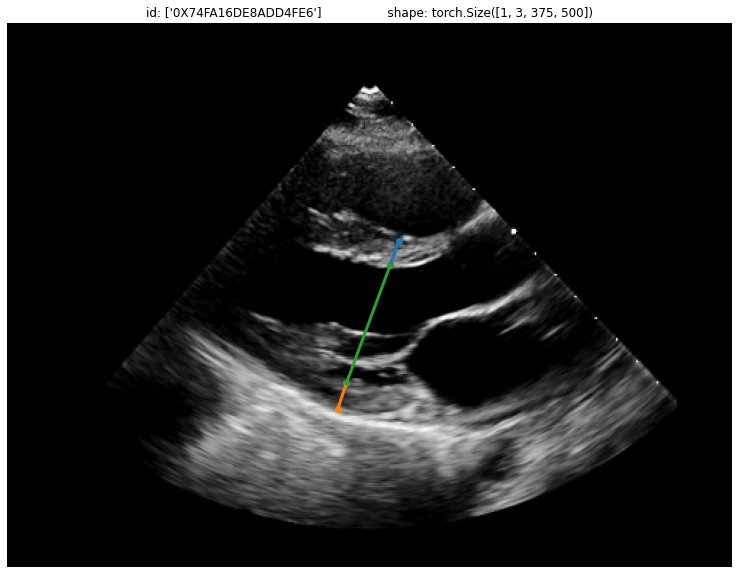

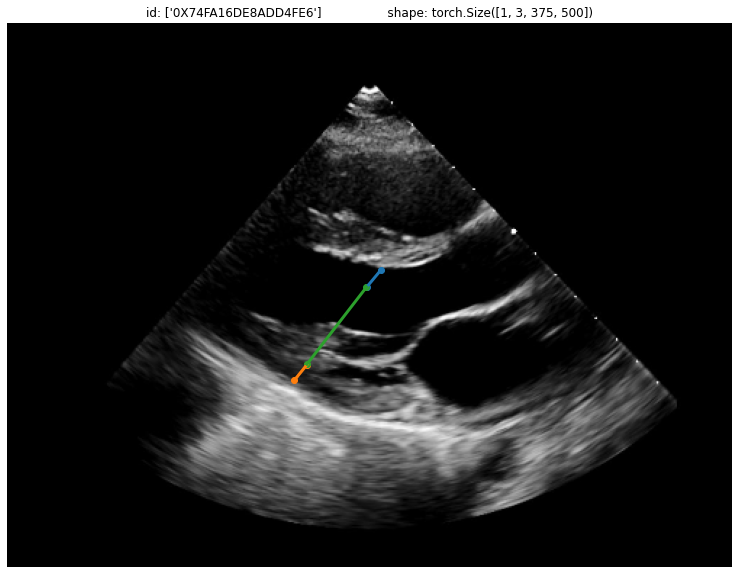

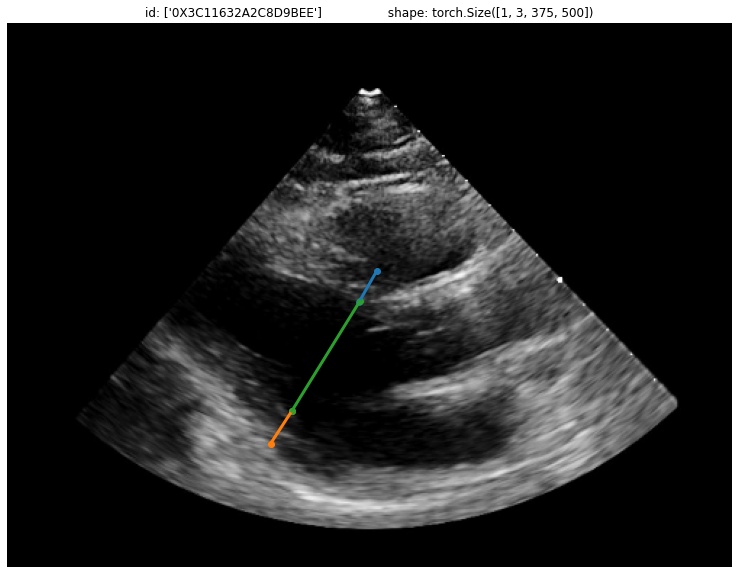

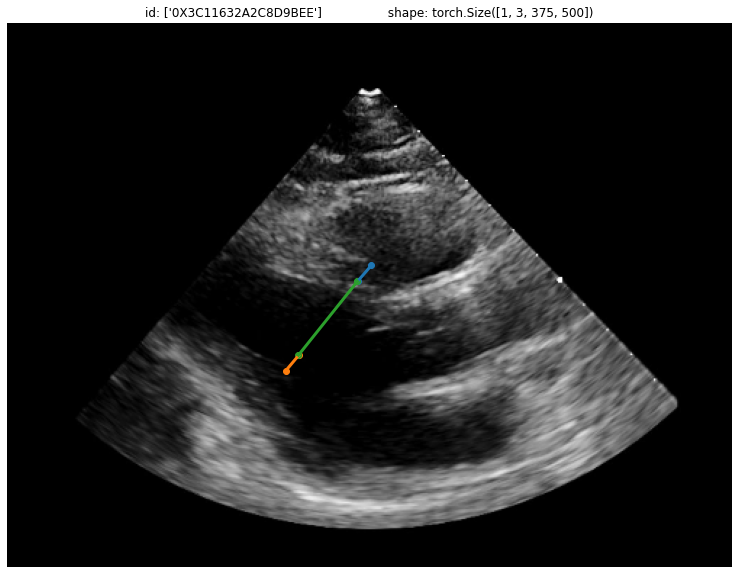

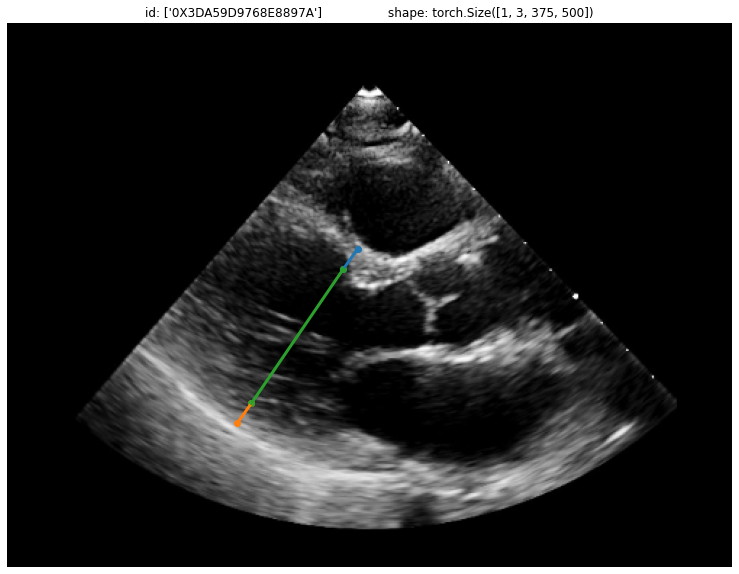

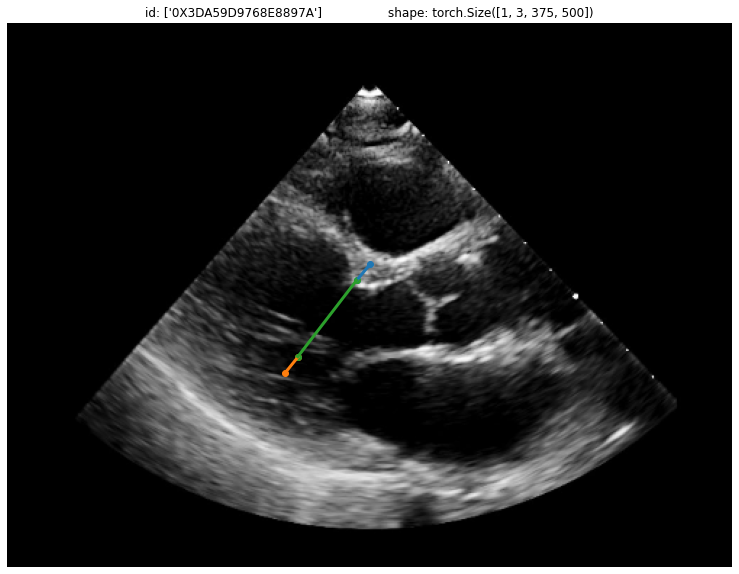

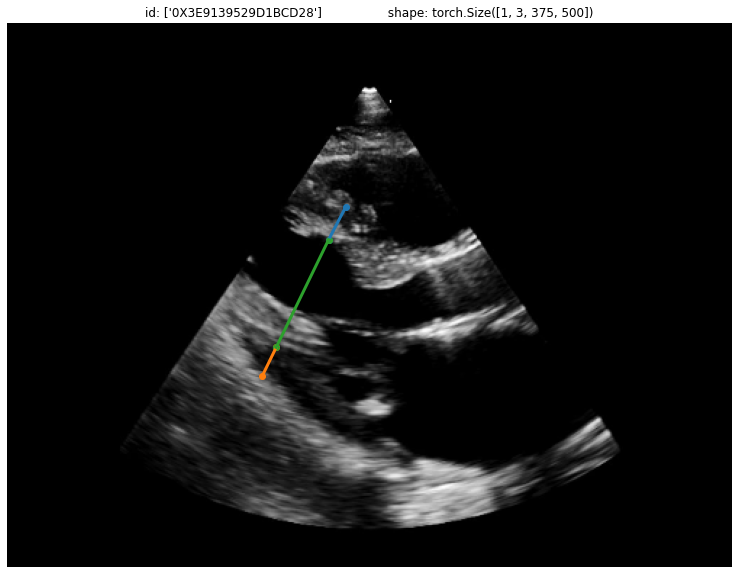

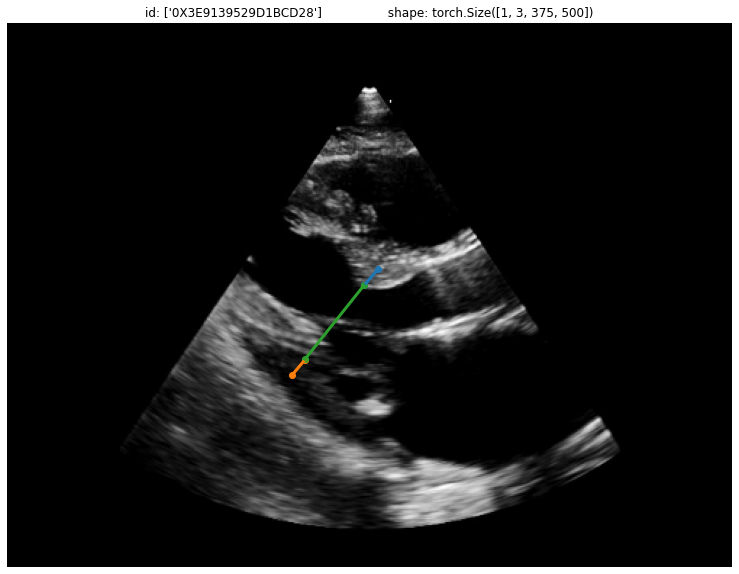

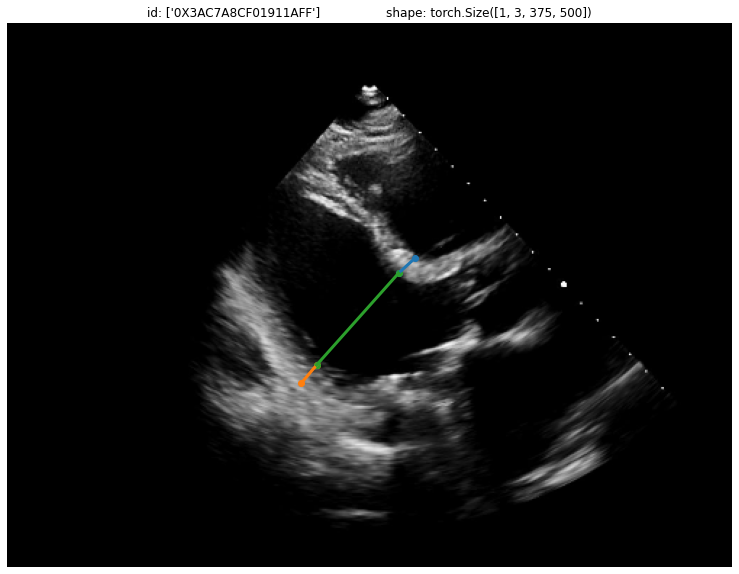

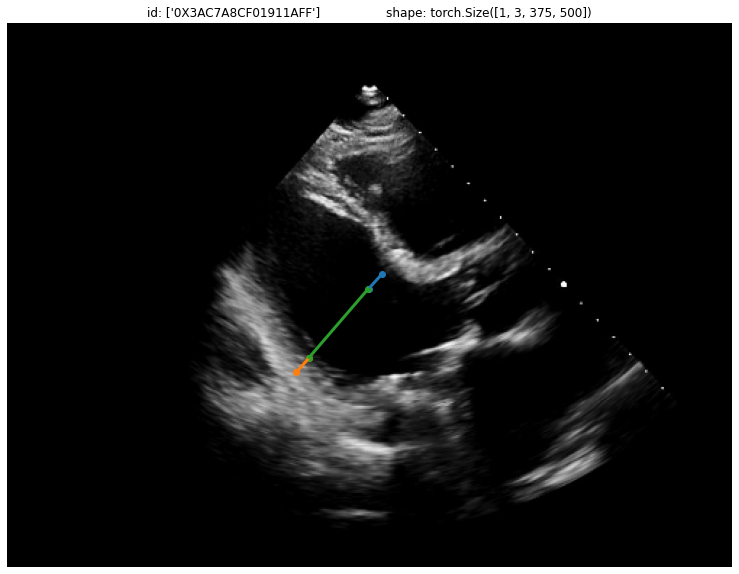

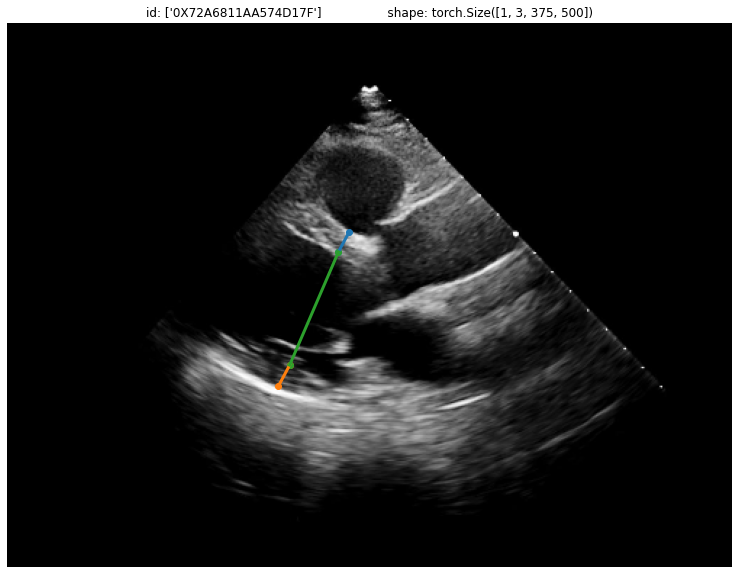

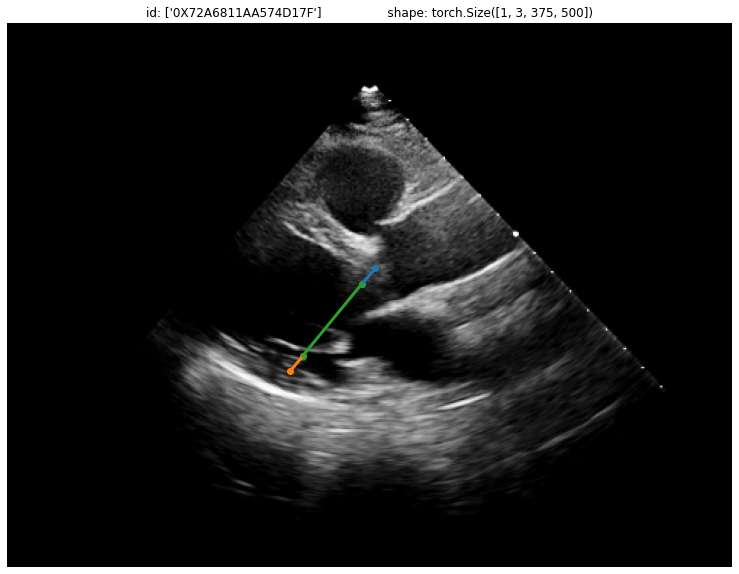

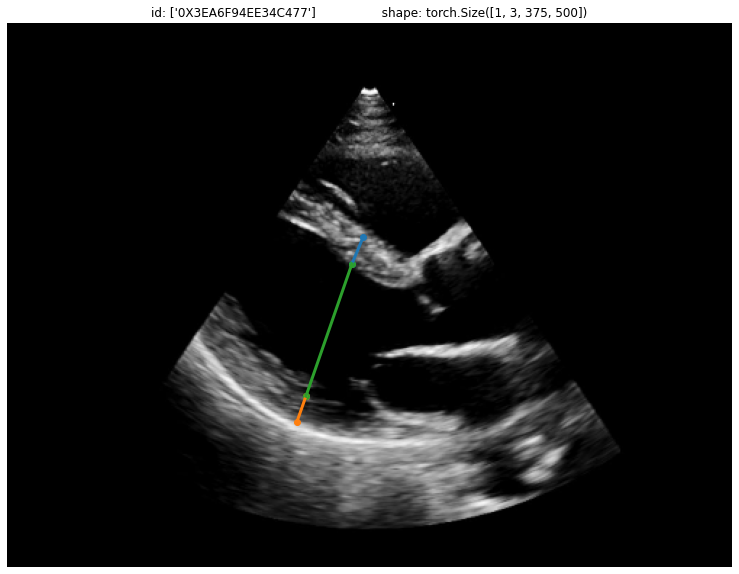

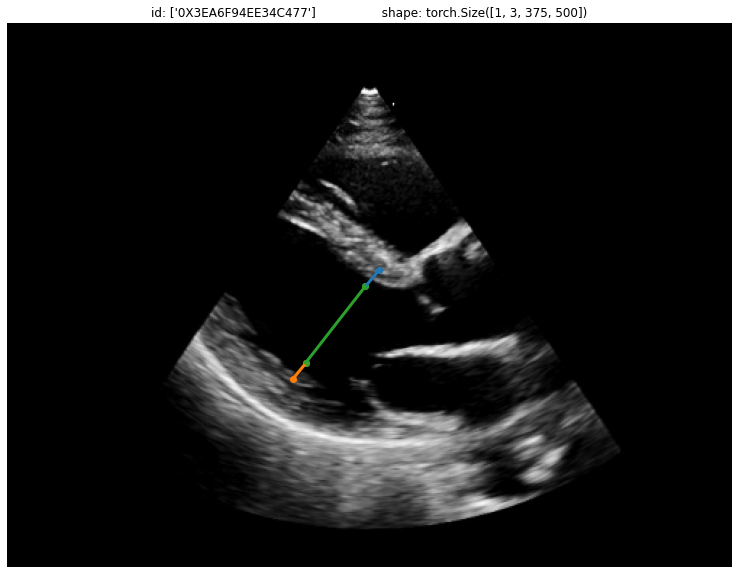

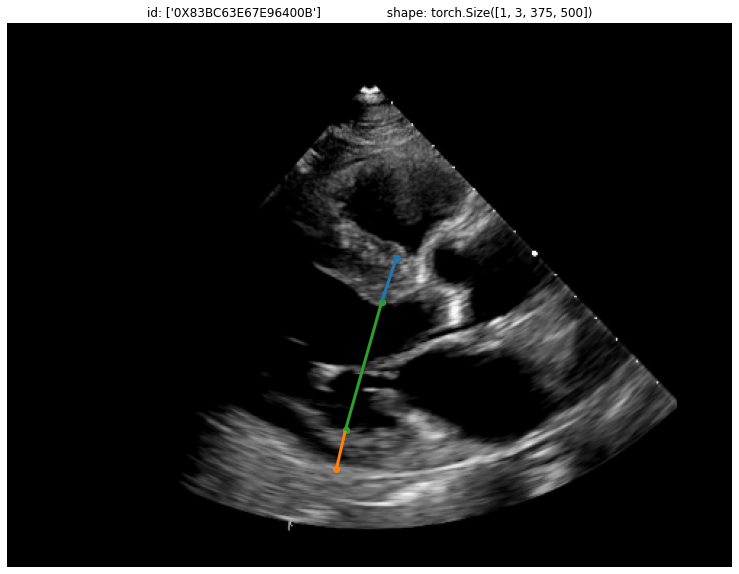

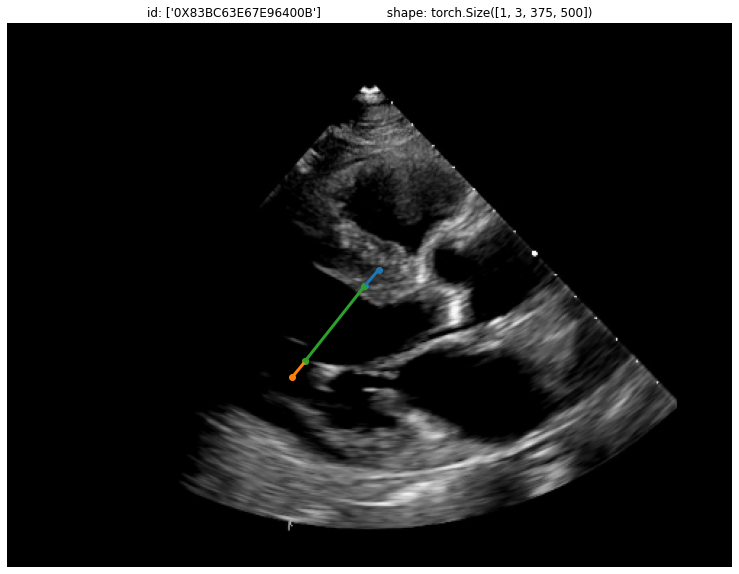

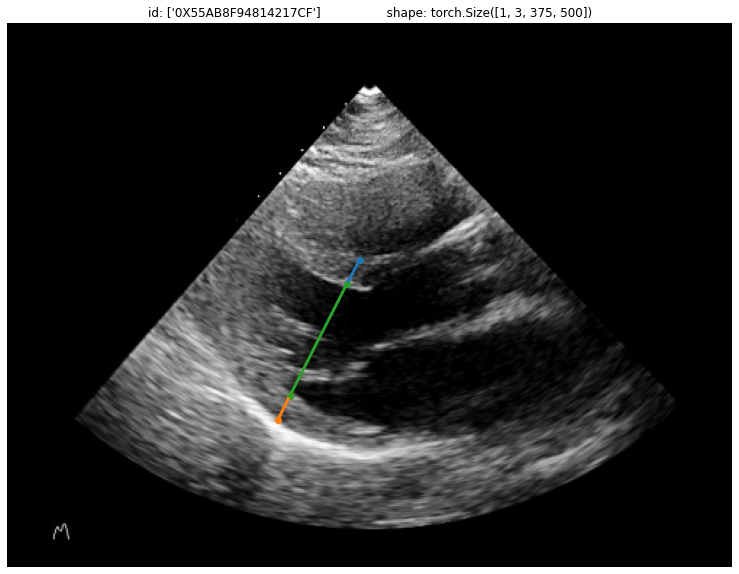

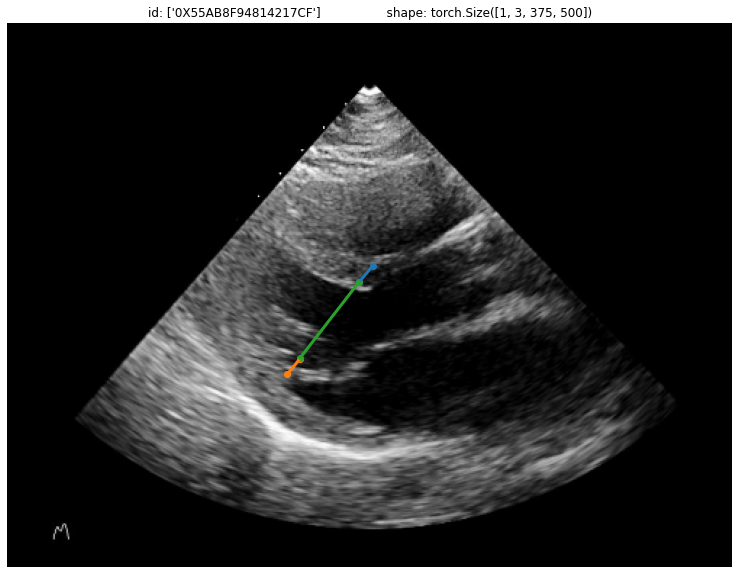

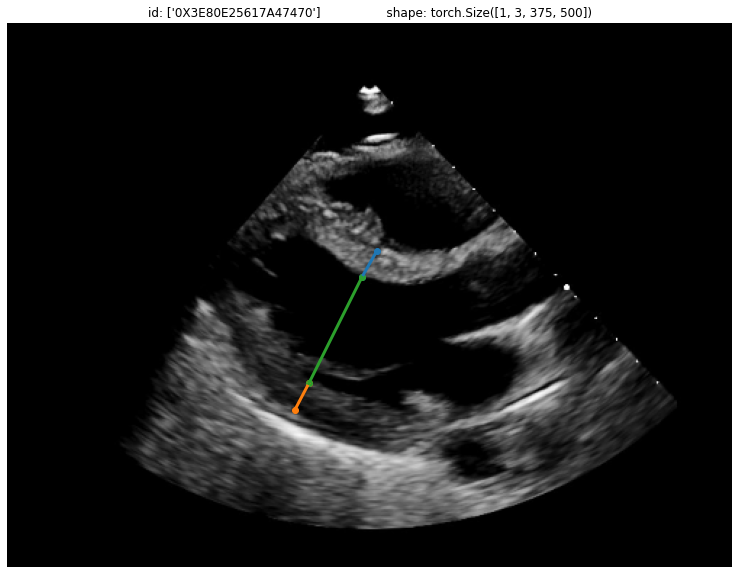

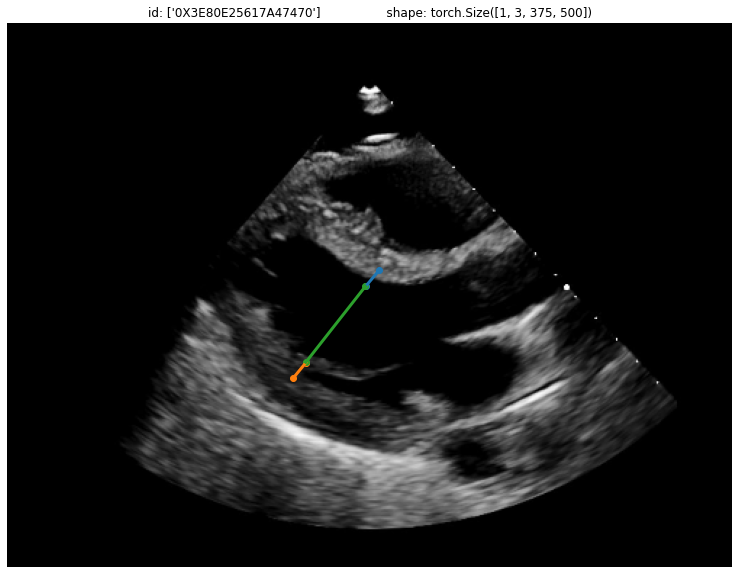

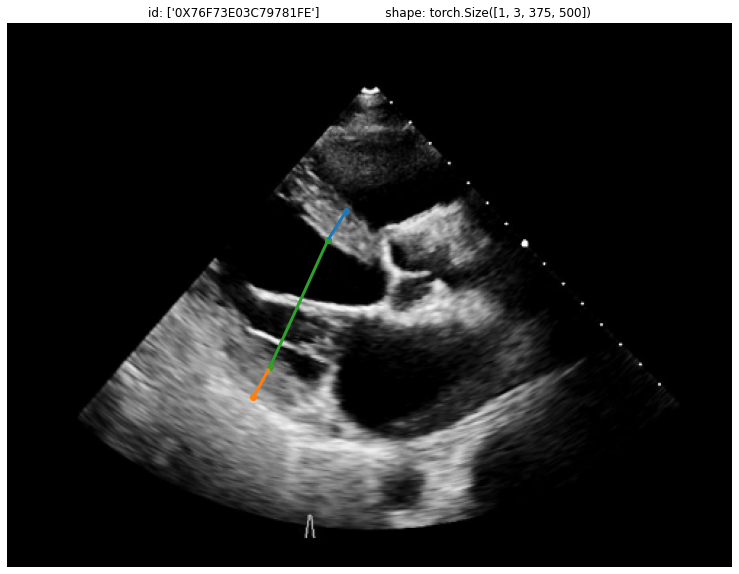

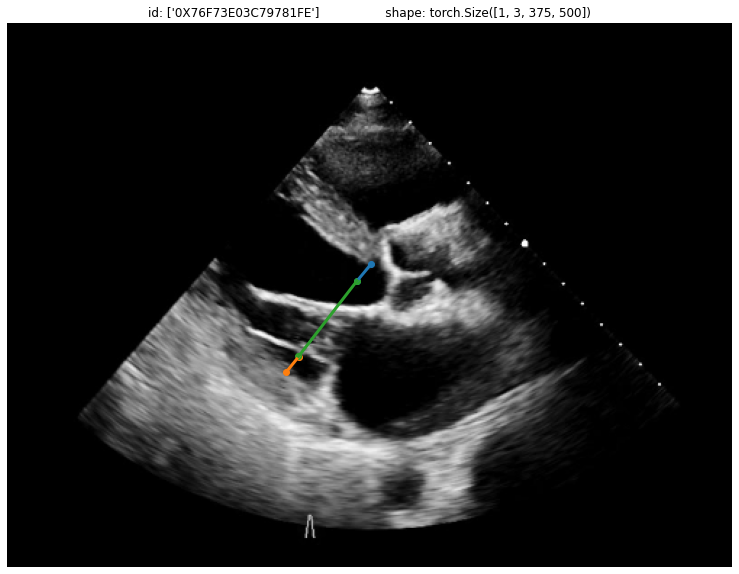

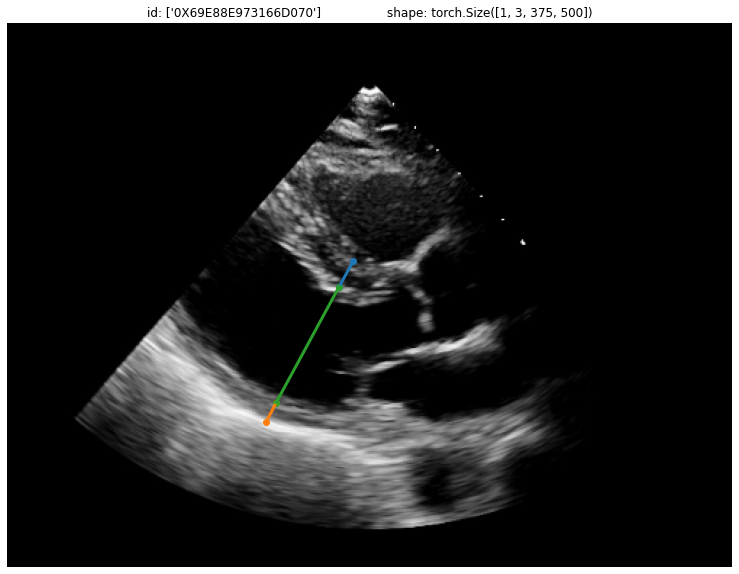

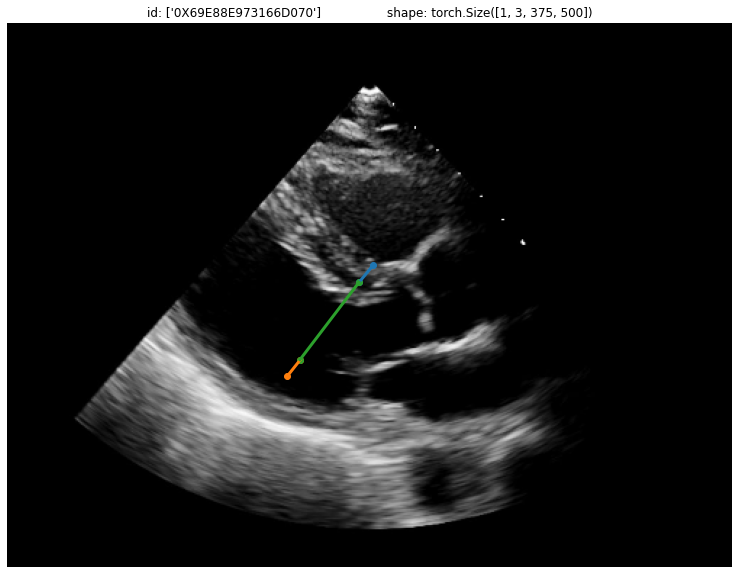

KeyboardInterrupt: 

In [60]:
preds = []
for sample in train_dl:
    pred = model(sample['data'].to(CFG['device'])).detach().cpu()
    show_lvh(sample)
    show_lvh(sample, pred)


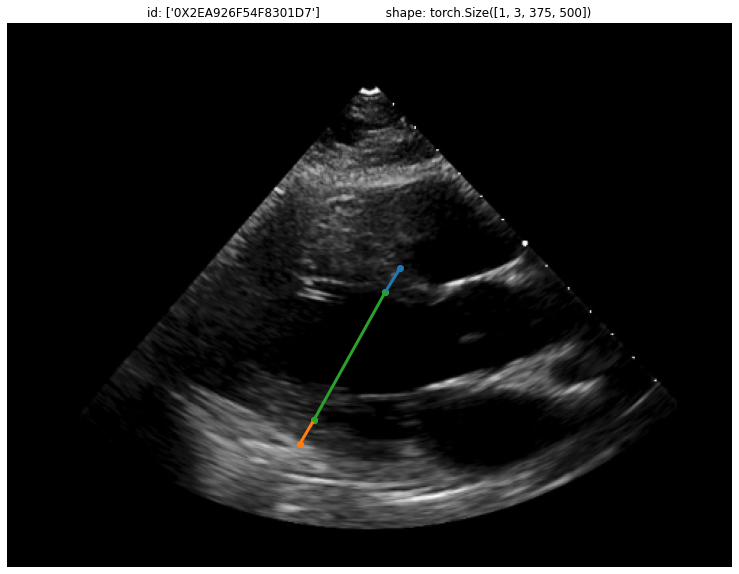

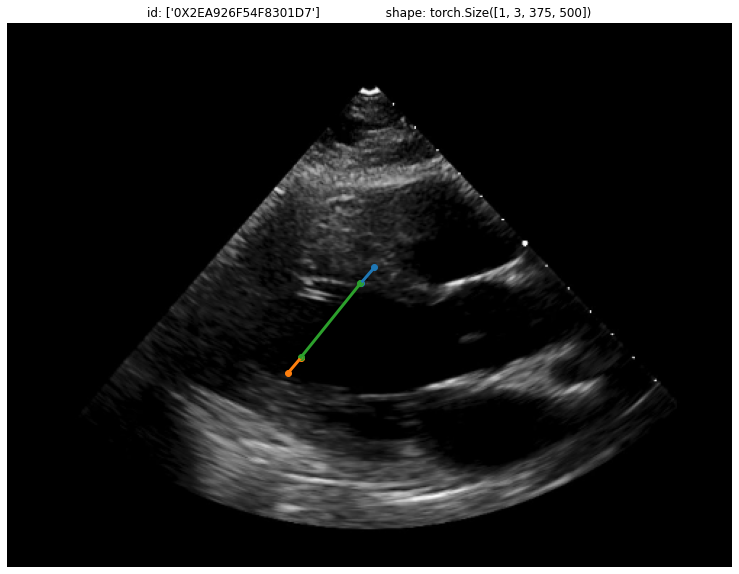

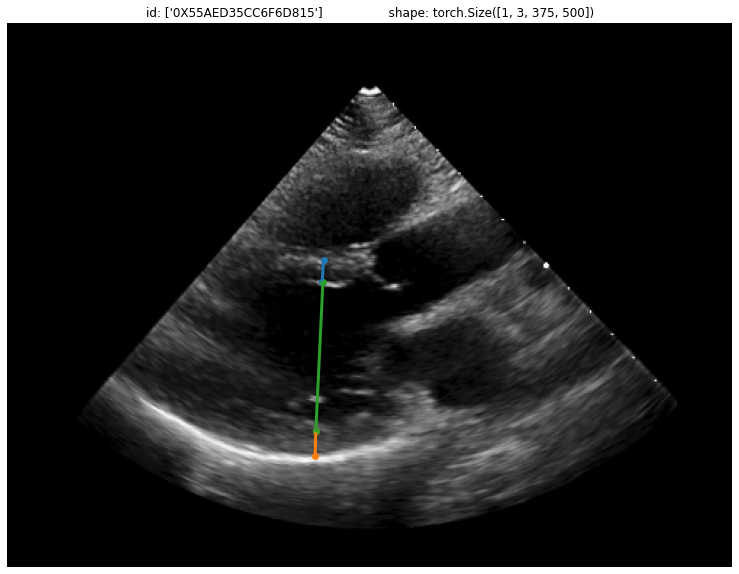

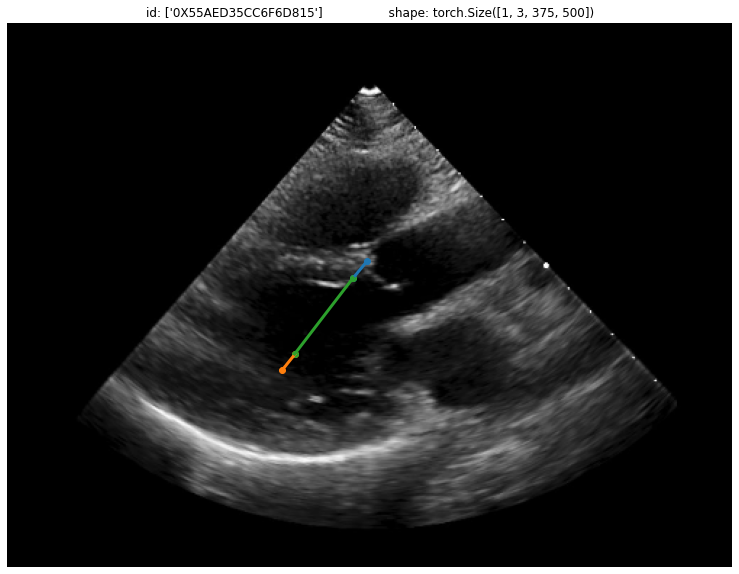

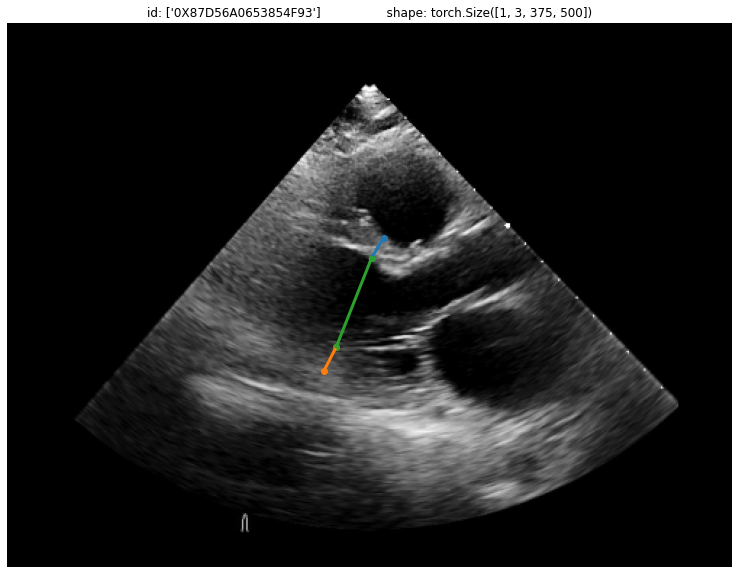

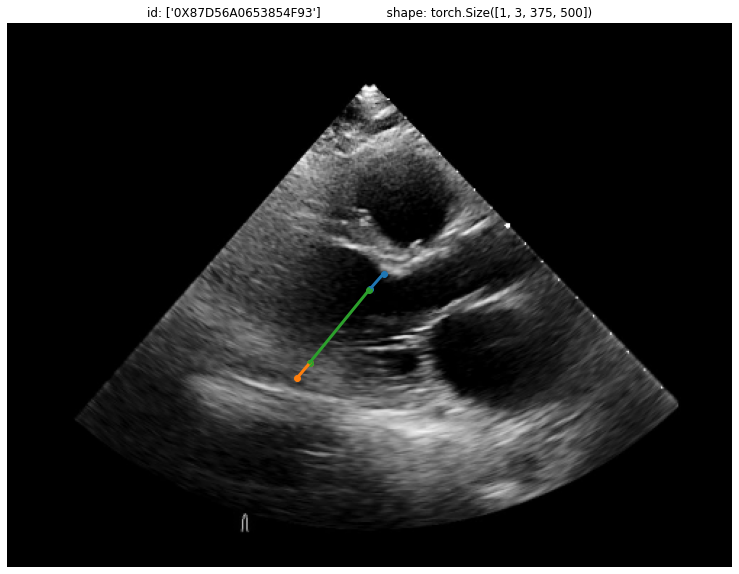

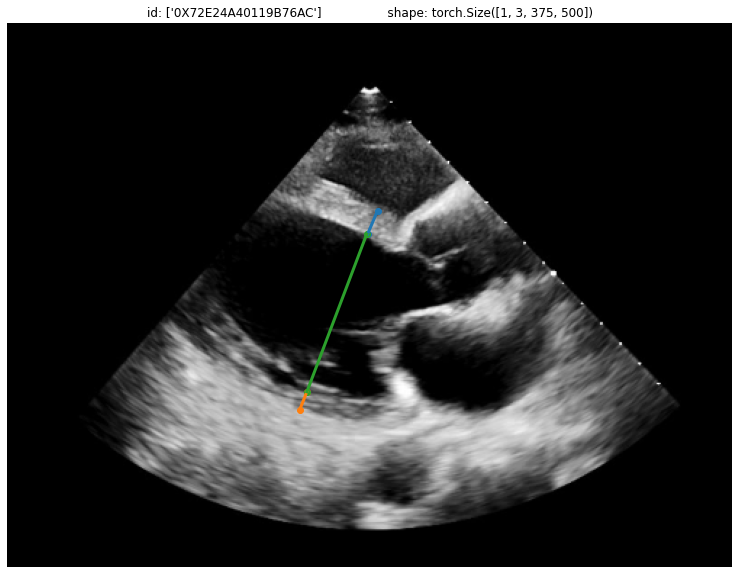

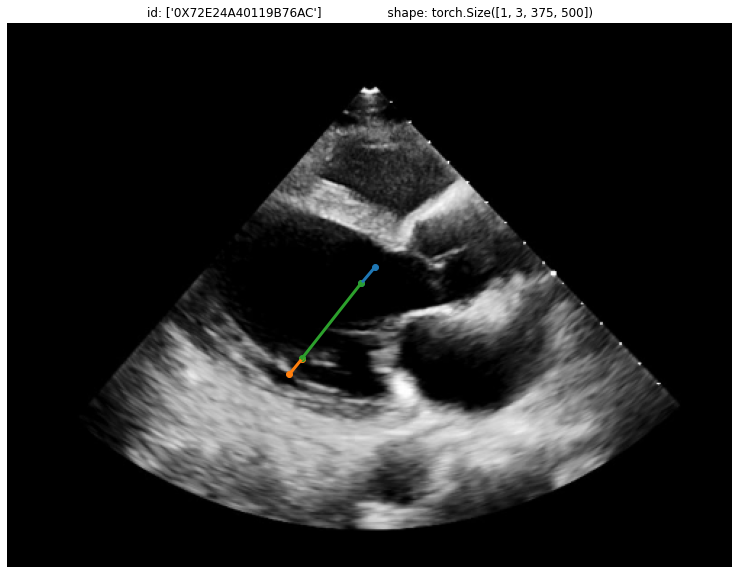

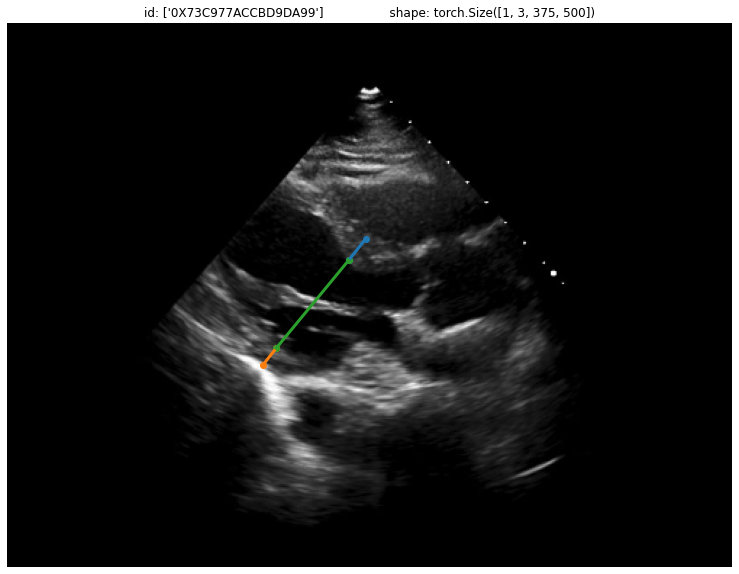

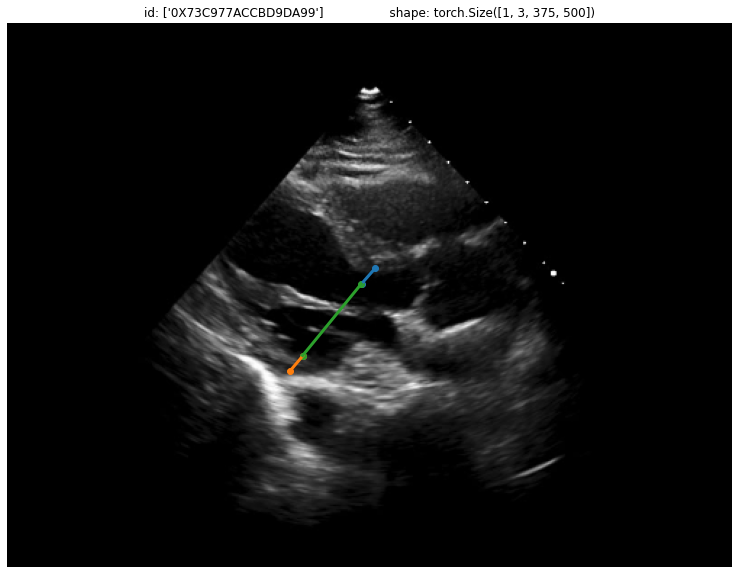

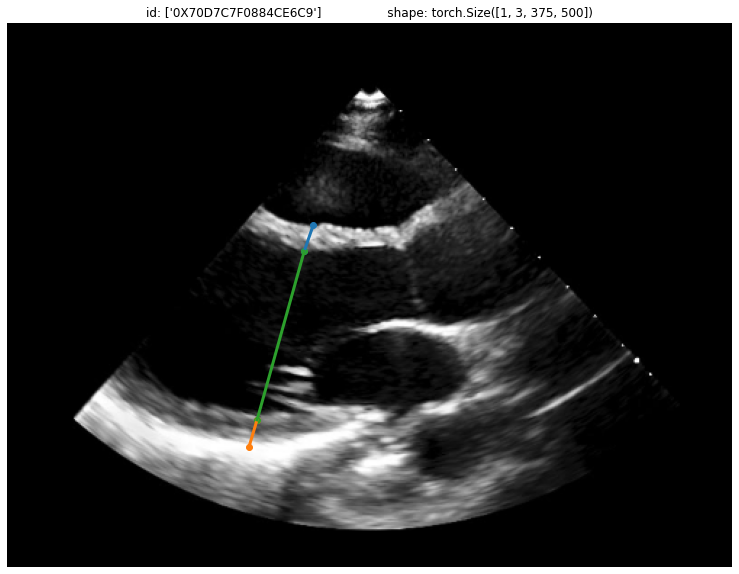

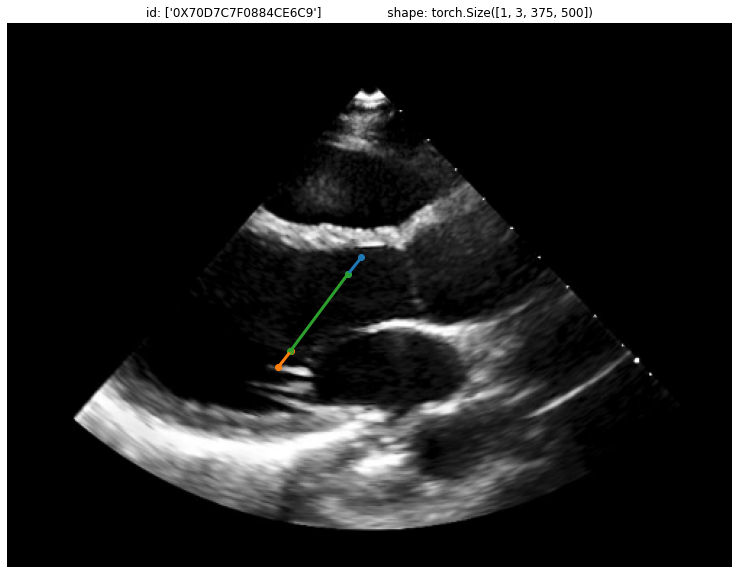

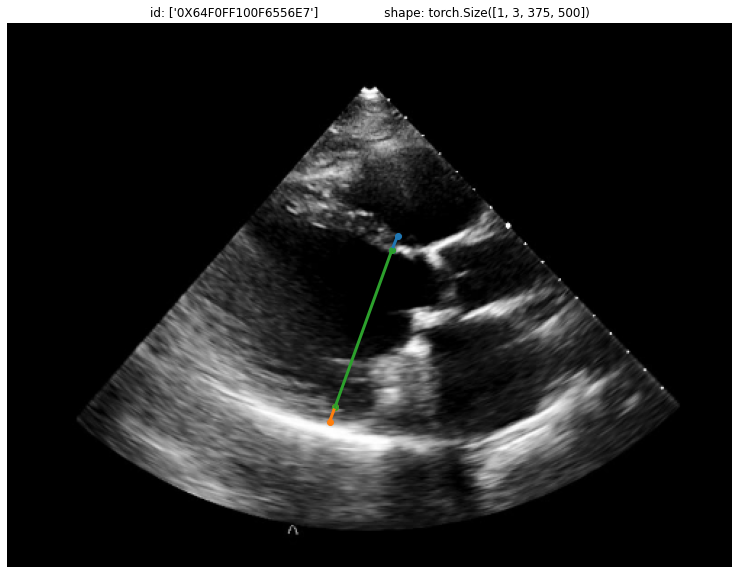

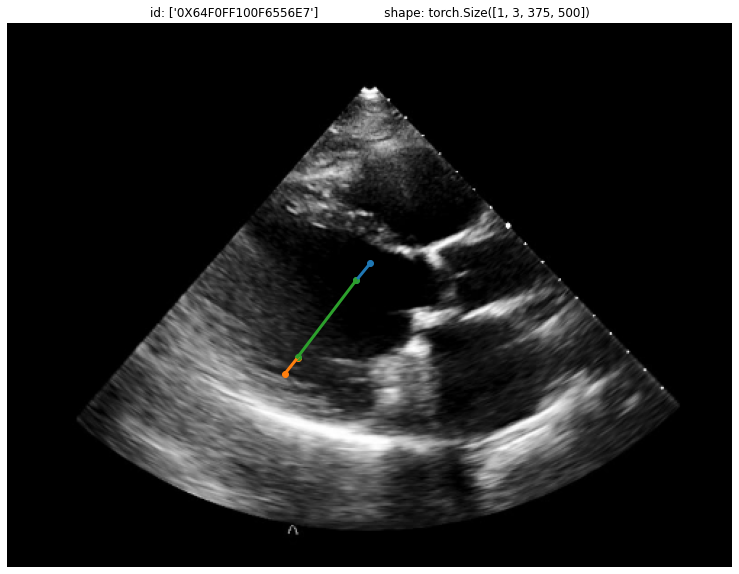

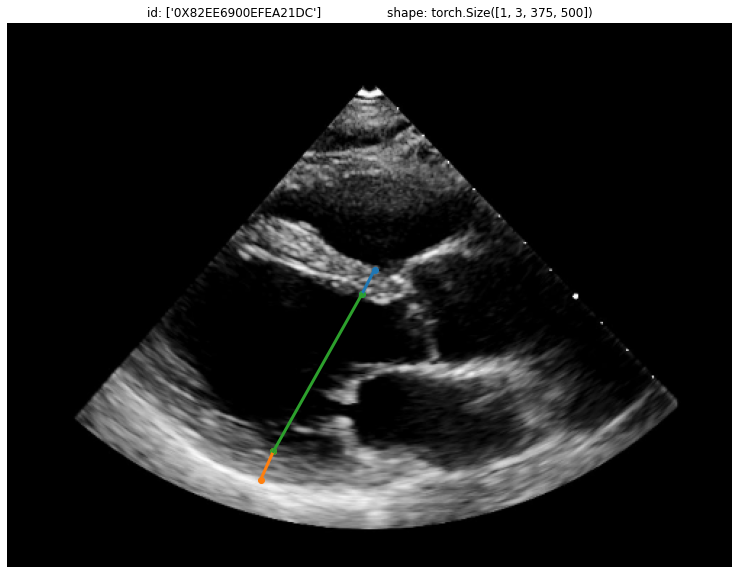

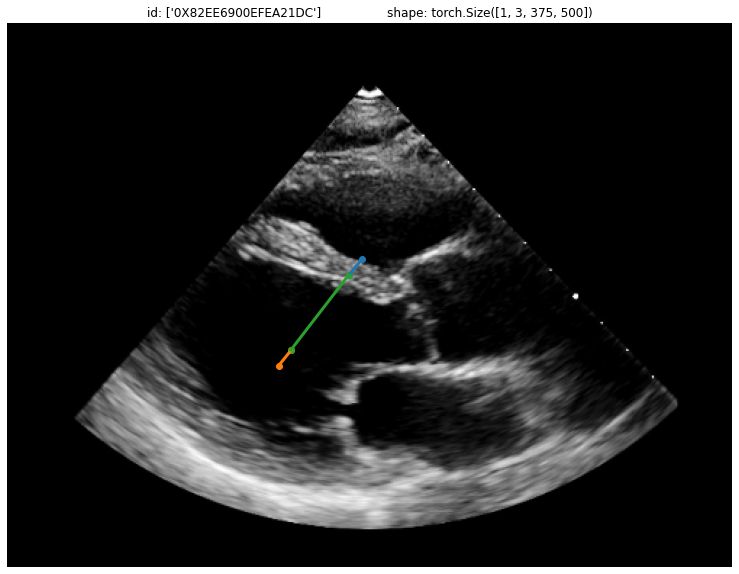

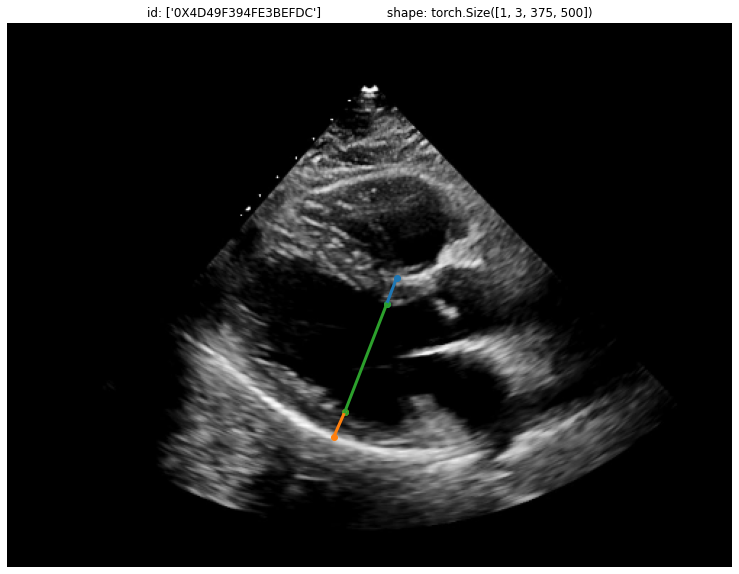

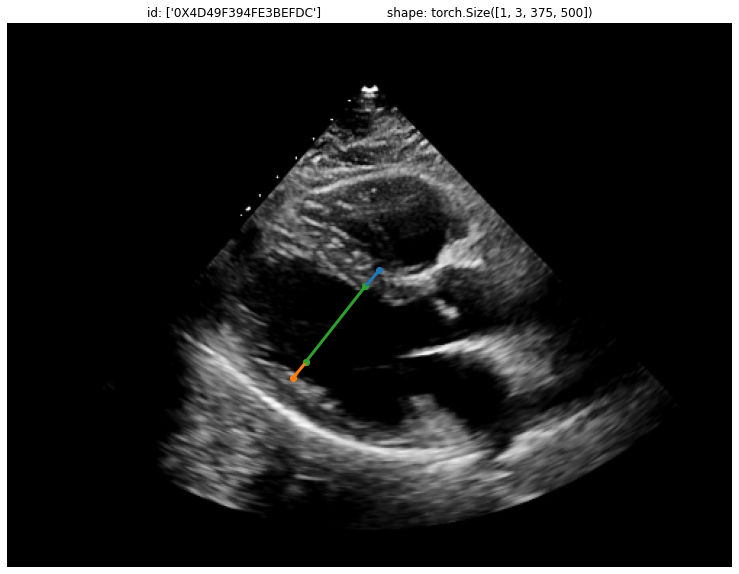

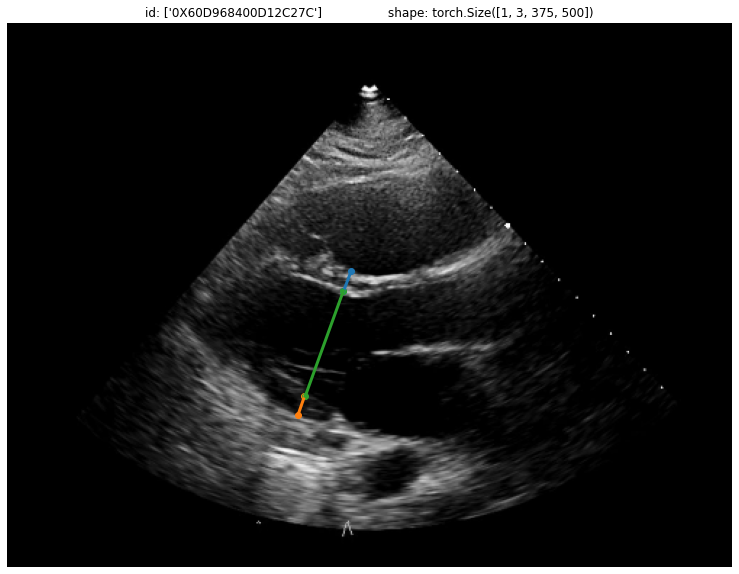

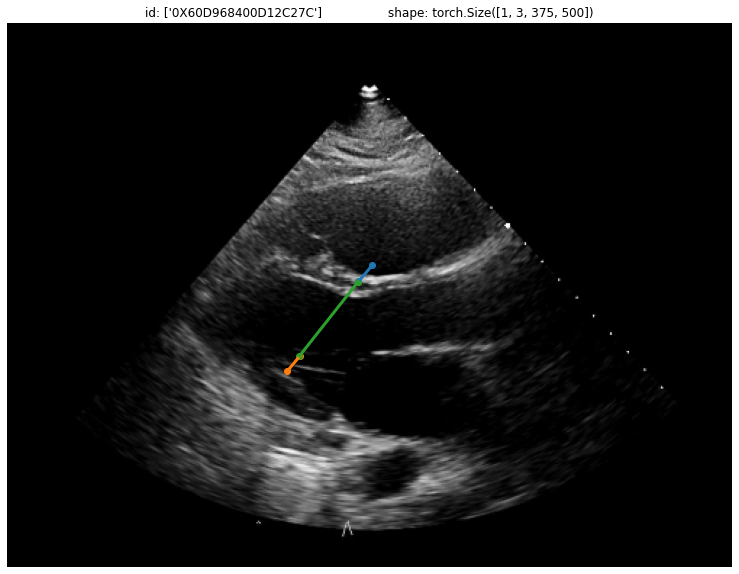

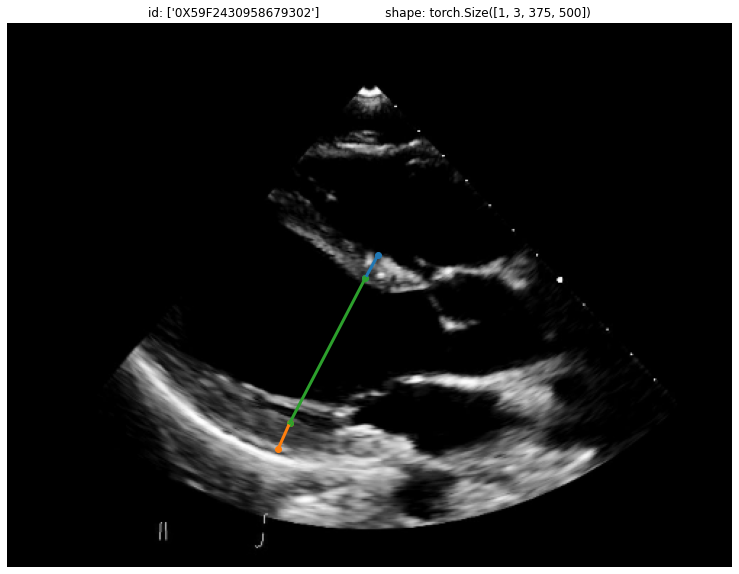

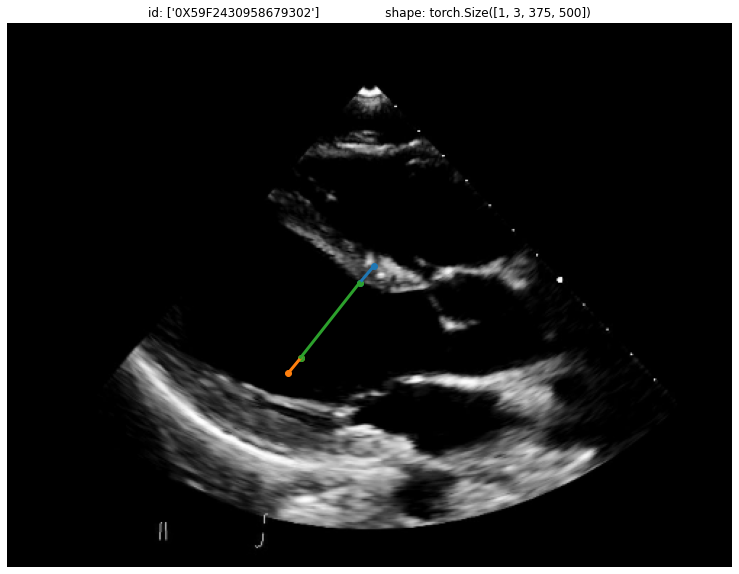

KeyboardInterrupt: 

In [ ]:
valid_dl = DataLoader(valid_ds, batch_size=1, shuffle=False)
preds = []
for sample in valid_dl:
    pred = model(sample['data'].to(CFG['device'])).detach().cpu()
    show_lvh(sample)
    show_lvh(sample, pred)
